Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/04/12

In [15]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
%matplotlib inline

sb.set_style('darkgrid')

# Prediction Model Comparison


### Question:

How well do Multiple and K-Nearest Neighbor (KNN) regression models predict a happiness score based on a number of features including life expectancy and family support?

### Data:
Both datasets were obtained from Kaggle’s web site, "World Happiness Report 2016
Happiness scored according to economic production, social support, etc." [2]


#### Context

The World Happiness Report is a landmark survey of the state of global happiness. The first report was published in 2012, the second in 2013, and the third in 2015. The World Happiness Report 2016 Update, which ranks 156 countries by their happiness levels, was released today in Rome in advance of UN World Happiness Day, March 20th. Leading experts across fields – economics, psychology, survey analysis, national statistics, health, public policy and more – describe how measurements of well-being can be used effectively to assess the progress of nations. The reports review the state of happiness in the world today and show how the new science of happiness explains personal and national variations in happiness. They reflect a new worldwide demand for more attention to happiness as a criteria for government policy [3].

#### Content

The happiness scores and rankings use data from the Gallup World Poll. The scores are based on answers to the main life evaluation question asked in the poll. This question, known as the Cantril ladder, asks respondents to think of a ladder with the best possible life for them being a 10 and the worst possible life being a 0 and to rate their own current lives on that scale. The scores are from nationally representative samples for the years 2013-2015 and use the Gallup weights to make the estimates representative. The columns following the happiness score estimate the extent to which each of six factors – economic production, social support, life expectancy, freedom, absence of corruption, and generosity – contribute to making life evaluations higher in each country than they are in Dystopia, a hypothetical country that has values equal to the world’s lowest national averages for each of the six factors. They have no impact on the total score reported for each country, but they do explain why some countries rank higher than others [2].

1.  GDP per capita is in terms of Purchasing Power Parity (PPP) adjusted to constant 2011 international dollars, taken from the World Development Indicators (WDI) released by the World Bank in December 2015.

2.  The time series of healthy life expectancy at birth are constructed based on data from the World Health Organization (WHO) and the World Development Indicators (WDI). WHO publishes the data on healthy life expectancy for the year 2012. The time series of life ex-pectancies, with no adjustment for health, are available in WDI. 

3.  Family - Social support (or having someone to count on in times of trouble) is the national average of the binary responses (either 0 or 1) to the Gallup World Poll (GWP) question “If you were in trouble, do you have relatives or friends you can count on to help you whenev-er you need them, or not?” 

4.  Freedom to make life choices is the national average of binary responses to the GWP question “Are you satisfied or dissatisfied with your freedom to choose what you do with your life?” 

5.  Generosity is the residual of regressing the national average of GWP responses to the question “Have you donated money to a char-ity in the past month?” on GDP per capita.

6. Perceptions of corruption are the average of binary answers to two GWP questions: “Is corruption widespread throughout the gov-ernment or not” and “Is corruption wide-spread within businesses or not?” Where data for government corruption are missing, the perception of business corruption is used as the overall corruption-perception measure [3]. 


### Models:

K Nearest Neighbors Regression 

Similar to KNN for classification except that the regression version is used for estimating a continuous variable.  KNN Regression can be conducted via the following steps [1].

1. Compute the Euclidean distance from the query data to the trained data set. 
2. Order the trained data set  by increasing distance. 
3. Find a heuristically optimal number k of nearest neighbors, based on Root Mean Squared Error. This is done using cross validation. 
4. Calculate an inverse distance weighted average with the k-nearest multivariate neighbors.

Multiple Regression

$$Happiness = \alpha + \beta_1Economy+ \beta_2Family + \beta_3Health + \beta_4Government Corruption + \beta_5Generosity$$

In [26]:
data_2015_path = '/media/ianh/space/ThinkfulData/WorldHappinessReport/2015.csv'
data_2016_path = '/media/ianh/space/ThinkfulData/WorldHappinessReport/2016.csv'
columns = ['Country', 'Happiness Score', 'Economy', 'Family', 'Health', 'Government Corruption', 'Generosity']
data_2015 = pd.read_csv(data_2015_path,  usecols=columns)
print("Observations : %d \n" % (data_2015.shape[0]))
data_2015.head()

Observations : 158 



,Country,Happiness Score,Economy,Family,Health,Government Corruption,Generosity
0,Switzerland,7.587,1.39651,1.34951,0.94143,0.41978,0.29678
1,Iceland,7.561,1.30232,1.40223,0.94784,0.14145,0.43630
2,Denmark,7.527,1.32548,1.36058,0.87464,0.48357,0.34139
3,Norway,7.522,1.45900,1.33095,0.88521,0.36503,0.34699
4,Canada,7.427,1.32629,1.32261,0.90563,0.32957,0.45811


## Preprocessing and exploratory data analysis 

In [6]:
# Check for missing data
data_2015.isnull().sum()

Country                  0
Happiness Score          0
Economy                  0
Family                   0
Health                   0
Government Corruption    0
Generosity               0
dtype: int64

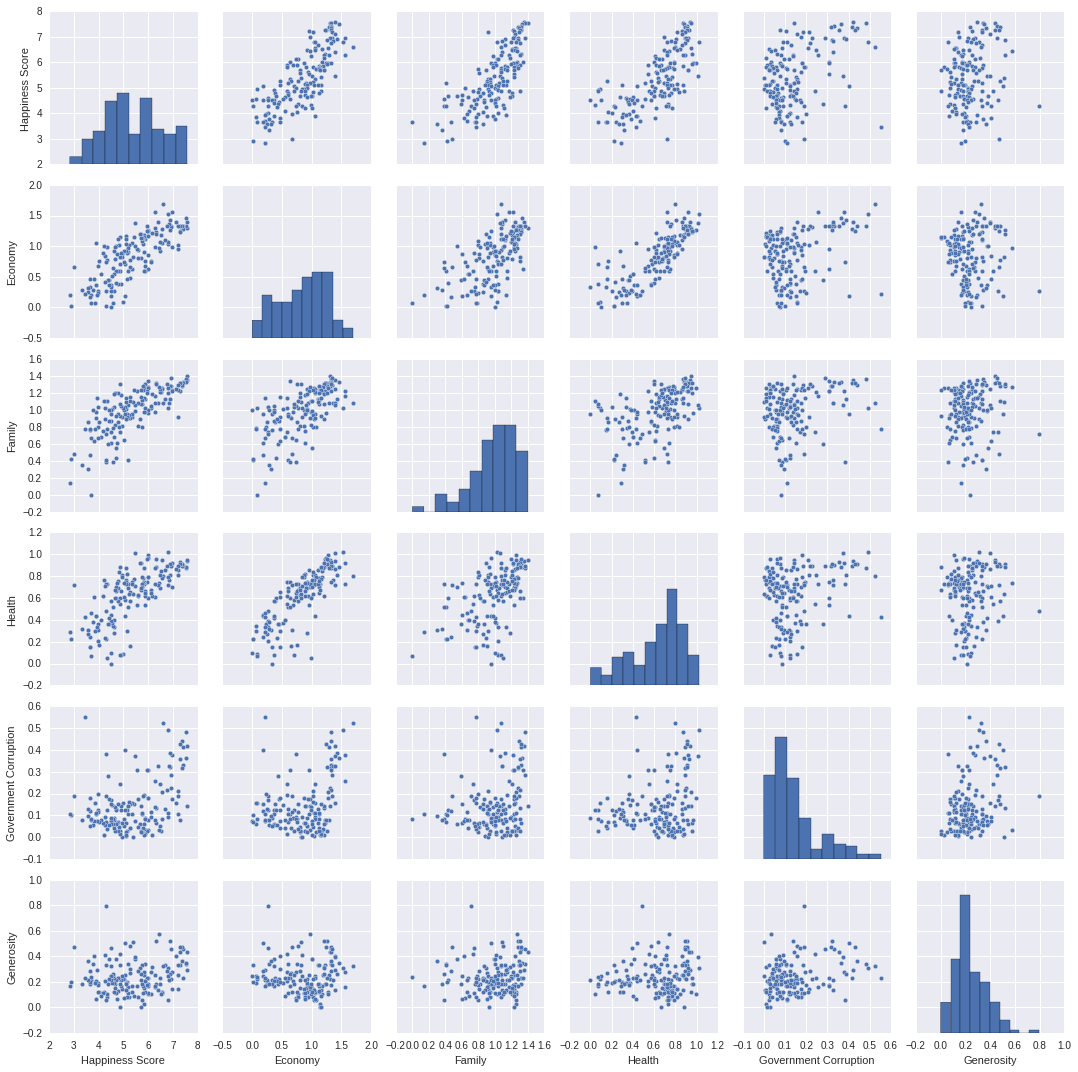

In [8]:
# Visually check for outliers and distribution of column data with pair plot
_ = sb.pairplot(data_2015)

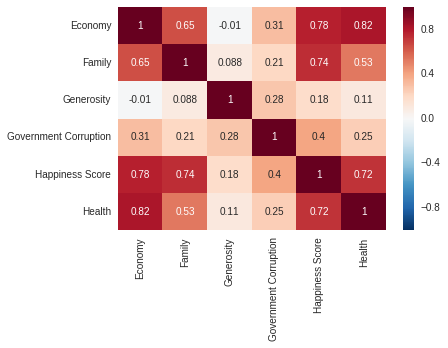

In [14]:
# Display heatmap for correlations between the different features
exclude = ['Country']
# Compute the correlation matrix after excluding the country column
corr = data_2015.ix[:, data_2015.columns.difference(exclude)].corr()
_  = sb.heatmap(corr, annot=True)

Most of the feature distributions are non Gaussian and there is a degree of multicollinearity.  Most noticeably with Economy, Health and Happiness.   Hard to imagine how this features could not be correlated in some manner as a country with with a strong economy and healthy individuals would not have a high sense of happiness.

Some data transformations will be carried out on the features to have them resemble a more normal distribution.   From the appearance of the scatter plots either a power (for those values skewed towards the lower end) or a root (for those values skewed towards the higher end) transformation will be carried out.

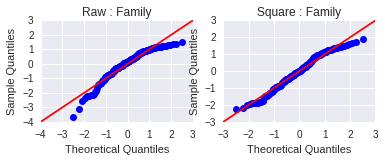

In [23]:
# transformation of Family (Social Support)
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(data_2015.Family, line='45', fit=True, ax=ax)
ax.set_title('Raw : Family')

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(np.square(data_2015.Family), line='45', fit=True, ax=ax)
ax.set_title('Square : Family')

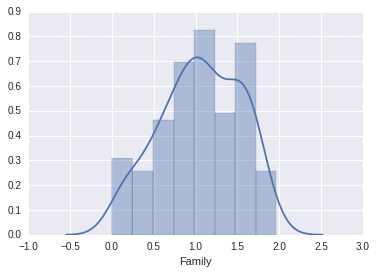

In [22]:
_ = sb.distplot(np.square(data_2015.Family))

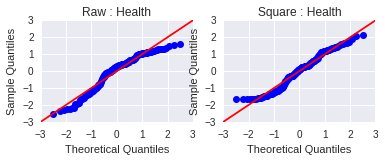

In [25]:
# transformation of Health (Life Expectancy)
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(data_2015.Health, line='45', fit=True, ax=ax)
ax.set_title('Raw : Health')

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(np.square(data_2015.Health), line='45', fit=True, ax=ax)
ax.set_title('Square : Health')

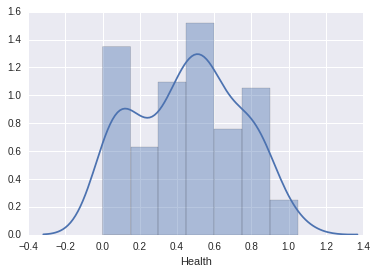

In [34]:
_ = sb.distplot(np.square(data_2015['Health']))

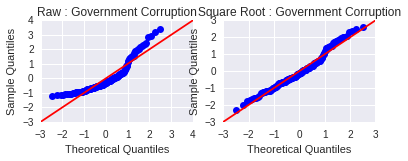

In [28]:
# transformation of Government Corruption
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(data_2015['Government Corruption'], line='45', fit=True, ax=ax)
ax.set_title('Raw : Government Corruption')

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(np.sqrt(data_2015['Government Corruption']), line='45', fit=True, ax=ax)
ax.set_title('Square Root : Government Corruption')

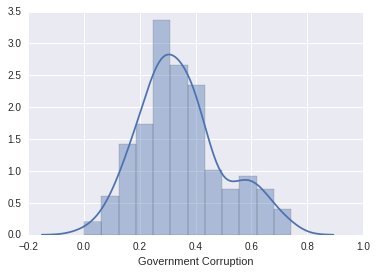

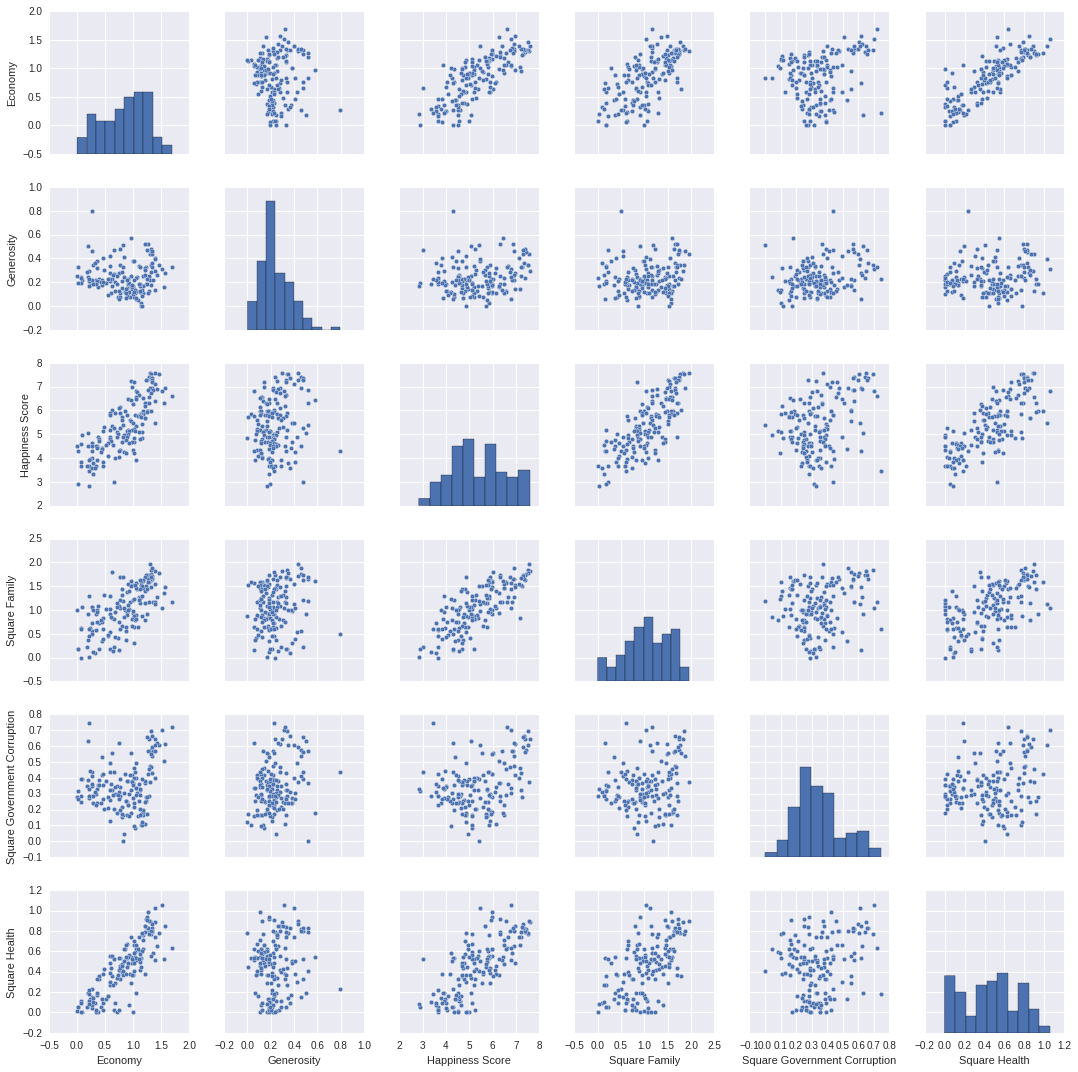

In [37]:
# Adding the Square of the raw Family data points into data frame.
data_2015['Square Family'] = np.square(data_2015.Family)

# Taking the square of Health data points and creating a new data frame column.
data_2015['Square Health'] = np.square(data_2015.Health)

# Taking the square root of Government Corruption data points.
data_2015['Square Government Corruption'] = np.sqrt(data_2015['Government Corruption'])

# filtering out those columns no longer needed for model building
exclude = ['Country', 'Family', 'Health', 'Government Corruption']

_ = sb.pairplot(data_2015.ix[:, data_2015.columns.difference(exclude)])

## Model Building

## References

1. https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#k-NN_regression

2. https://www.kaggle.com/unsdsn/world-happiness

3. http://worldhappiness.report/wp-content/uploads/sites/2/2016/03/HR-V1_web.pdf